# Homework 3 - CNN on Multilabel remote sensing images
## By: Syed Ali Murad Tahir

In this homework we will be performing CNN on UCMerced dataset. This dataset contains Multispectral images. 


The task is divided into following step

1)  Prepairing data
2) The data we get, we divide that data, into training, test and validation. We divide training data into training and test
3) To pretrain the model in order to avoid overfitting, we can use pretrained data already provided to us. Or, we can perform data augmentation to pre train the data so we have more samples of data
4) Now we perform Convolution. So we choose the number of layers, neuron in that layer and the activation function of that layer 
5) Then we add Max pooling to take out dominant features
6) We can add dropout
7) Then we have to perform flatten the data
8) We can add a desne layer (Check if we need it or not) -> These are actually the hidden layers we specify when performing forward propgation
9) Then we train or data
10) After that we check our results on test data to check for overfitting
11) At the end we check validation




## Understanding the dataset

This is a 21 class land use image dataset meant for research purposes. However, for multilabel, we only have 17 labels

There are 100 images for each of the following classes:
    
    
 1) airplane	
 2) bare-soil	
 3) buildings	
 4) cars	
 5) chaparral	
 6) court	
 7) dock	
 8) field	
 9) grass	
 10) mobile-home	
 11) pavement	
 12) sand	
 13) sea	
 14) ship	
 15) tanks	
 16) trees	
 17) water

Each image measures 256x256 pixels.



## Imporint Libraries

In [32]:
import copy
import os
import numpy as np
import pandas as pd
import zipfile
from simple_downloader import download
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, average_precision_score, accuracy_score, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader

## Importing Dataset

In [ ]:
download_dir = Path("./Hw3_data")
download_dir.mkdir(exist_ok=True)

In [ ]:
TUB_URL = "https://tubcloud.tu-berlin.de/s/H4QHX5GPDY6wDog/download/UCMerced_LandUse.zip"
output_file = download(TUB_URL, "./Hw3_data/")

In [ ]:
zipf = zipfile.ZipFile(output_file)
zipf.extractall(path="Hw3_data")

## Visualizing our Dataset

In [2]:
#Go to different file directory
path = os.path.join("/notebooks", "Hw3_data", "UCMerced_LandUse", "multilabels", "")
os.chdir(path)




# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))


data = pd.DataFrame(pd.read_excel("LandUse_Multilabeled.xlsx"))
data

Current working directory: /notebooks/Hw3_data/UCMerced_LandUse/multilabels


,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,agricultural00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,agricultural01,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,agricultural02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,agricultural03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,agricultural04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,tenniscourt95,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
2096,tenniscourt96,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2097,tenniscourt97,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2098,tenniscourt98,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0


            Number of labels
airplane                 100
bare-soil                718
buildings                691
cars                     886
chaparral                115
court                    105
dock                     100
field                    103
grass                    975
mobile-home              102
pavement                1300
sand                     294
sea                      100
ship                     102
tanks                    100
trees                   1009
water                    203


Text(0.5, 1.0, 'Total no. of labels that belong to each class')

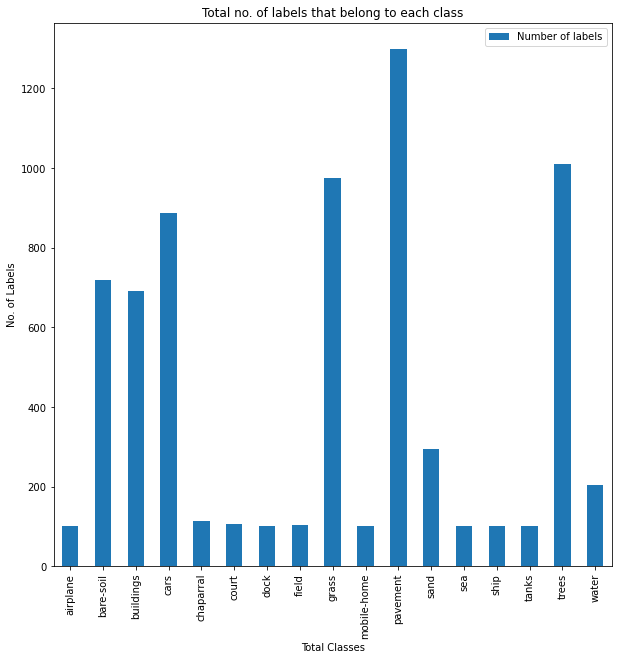

In [3]:
result = data.sum(axis="rows")
df = pd.DataFrame(result,columns=['Number of labels'])   #Convert into Data Frame
#Drop the first row
df.drop(index=df.index[0], 
        axis=0, 
        inplace=True)
print(df)


df.plot.bar(figsize=(10,10))
plt.xlabel("Total Classes")
plt.ylabel("No. of Labels")
plt.title("Total no. of labels that belong to each class")

## Designing Data Pipeline


In [4]:
class UCMerced(Dataset):
    def __init__(self, root_dir, img_transform=None, multilabel=True):

        self.root_dir = root_dir
        self.images_path = os.path.join(root_dir, "Images")
        self.class_names = sorted(
            [cl for cl in os.listdir(self.images_path) if not cl.startswith(".")]
        )
        self.img_paths, self.img_labels = self.init_dataset()
        self.img_transform = img_transform

        if multilabel:
            self.img_labels = self.read_multilabels()  # important for loss calculation
            self.img_labels = self.img_labels.astype(float)

    def init_dataset(self):
        img_paths, img_labels = [], []
        for cl_id, cl_name in enumerate(self.class_names):
            cl_path = os.path.join(self.images_path, cl_name)

            for img in sorted(os.listdir(cl_path)):
                img_path = os.path.join(cl_path, img)
                img_paths.append(img_path)
                img_labels.append(cl_id)

        return img_paths, img_labels

    def read_multilabels(self):
        label = pd.read_excel("./Hw3_data/UCMerced_LandUse/multilabels/LandUse_Multilabeled.xlsx")
        label = label.set_index("IMAGE\LABEL")
        label = np.array(label)
        return label

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.img_transform is not None:
            img = self.img_transform(img)

        return dict(img=img, label=label)

    def __len__(self):
        return len(self.img_paths)

In [5]:
class MetricTracker(object):
    """Computes and stores the average and current value."""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def get_device(cuda_int):
    """Get Cuda-Device. If cuda_int < 0 compute on CPU."""
    if cuda_int < 0:
        print("Computation on CPU")
        device = torch.device("cpu")
    elif torch.cuda.is_available():
        print("Computation on CUDA GPU device {}".format(cuda_int))
        device = torch.device("cuda:{}".format(cuda_int))
    return device

When obtaining our dataset, we divide our data randomly into training, testing and validation. We use random_split to perform this task

In [8]:
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
from torchvision.models import ResNet18_Weights
from torch.optim import Adam



def get_dataset(root_dir, tr_transform,seed=1, multilabel=True):
    valid_no = int(2100*0.1)
    train_no = int(2100*0.7) 
    test_no = int(2100*0.2)
    
    
    np.random.seed(seed) #To make our models comparable our split are similar everytime
    
    ucm_dataset_tr = UCMerced(root_dir, img_transform=tr_transform, multilabel=multilabel)
    #ucm_dataset_te = UCMerced(root_dir, img_transform=te_transform, multilabel=multilabel)
    
    trainset ,validset, testset  = random_split(ucm_dataset_tr, [train_no, valid_no, test_no])
    
    return trainset ,validset, testset
    
    

In [9]:
#Create class labels
classLabels = ["airplane", "bare-soil", "buildings", "cars","chaparral", "court", "dock", "field", "grass", "mobile-home","pavement","sand", "sea","ship",
               "tanks", "trees", "water"]

import os
os.chdir("/notebooks")
os.getcwd()

'/notebooks'

In [33]:


def prettify_multilabel_confusion_matrix(conf_mat, class_names, normalize=False):
    f, axes = plt.subplots(3, 6 , figsize=(30, 15))
    axes = axes.ravel()
    for i, cl_name in enumerate(class_names):
        if normalize:
            disp = ConfusionMatrixDisplay(conf_mat[i] / np.sum(conf_mat[i]))
        else:
            disp = ConfusionMatrixDisplay(conf_mat[i])
        disp.plot(ax=axes[i], values_format=".4g")
        disp.ax_.set_title(cl_name)
        if i < 12:
            disp.ax_.set_xlabel("")
        if i % 6 != 0:
            disp.ax_.set_ylabel("")
        disp.im_.colorbar.remove()

    axes[17].axis("off")

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()


In [11]:
#Calculaing accuracy for multilabel classification
#Formula taken from the following website: https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

def Accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

# Training Design

In this part, we will be creating a CNN. In order to perform CNN, we had to perform the following tasks: 
1) Divide our data into training, test and validation. We use 70% data for training, 20% for testing and 10% for validation. 
2) We create the Convolution layer. In this case we use the pytorch pretrained resnet 18 model 
3) For criterion, we use a BCEWithLogitsLoss function. This is due to the fact that we want to perform multilabel classification 
4) For optimizer, we use Adam optimizer. It is the same as stochastic gradient descent 
5) We create a dense layer that used for training the model 
6) We evaluate the model in order to check whether the model is overfitting or underfitting 
7) Test the model for unseen data


In the first part, we divide our dataset into training test and validation. We provide 70% data to training, 10% to validation and 20% to testing. We already splitted the data randomly in the function get_dataset

In [13]:
#Choose our device
cuda_device = get_device(0)

#Choose our parameter
batch_size = 64


#Transform
ucm_mean = [0.595425, 0.3518577, 0.3225522]
ucm_std = [0.19303136, 0.12492529, 0.10577361]


tr_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

te_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)


Computation on CUDA GPU device 0


In [14]:
#Divide our data into training, testing and validation and upload them into the data loader

trainset, valset, testset = get_dataset(
    "./Hw3_data/UCMerced_LandUse",
    tr_transform=tr_transform,
    multilabel=True
)

In [15]:

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Define our Model

In [16]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 17) #21 - number of classes
model.to(cuda_device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Define our criterion and gradient descent as stochastic gradient 

 

In [17]:
import torch.optim as optim
from torch.optim import lr_scheduler


#Criterion
criterion = nn.BCEWithLogitsLoss().to(cuda_device)





# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00005)


## Define functions for training and validation

In this section, we have to perform training and validation. During validation, we extract the probabilities for each class. Then we threshold the values hence values > 0.5 -> 1 AND values < 0.5 -> 0.This make sure that the values are divided into postive and negatives before calcualting the confusion matrix.

For further understanding, the following website is extremely helpful: https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/Multi_Label_Model_Evaulation.ipynb#scrollTo=u4iBlAQIQven



In [18]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device, early_stop=False):
    train_losses, val_losses = [], []
    accuracy_scores = []
    average_precision_score = []
    best_model = copy.deepcopy(model)
    best_acc = 0
    best_epoch = 1

    for epoch in range(1, epochs + 1):

        print("Epoch {}/{}".format(epoch, epochs))
        print("-" * 10)

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        #val_loss = loss_tracker.avg, report = classification report, conf_mat = confusion matrix, avg_prec = average precision score, overall_acc = accuracy
        val_loss, report, conf_mat, avg_prec, accuracy = val_epoch(model, val_loader, criterion, device) 
        overall_acc = accuracy
        average_precision = avg_prec
        

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracy_scores.append(overall_acc)
        average_precision_score.append(average_precision)

        
        if best_acc < overall_acc:
            best_acc = overall_acc
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        if epoch - best_epoch > 10 and early_stop:
            break

    return best_model, train_losses, val_losses, accuracy_scores, average_precision_score

In [19]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    loss_tracker = MetricTracker()
    acc_tracker = MetricTracker()
    model.train()

    tqdm_bar = tqdm(train_loader, desc="Training: ")
    for batch in tqdm_bar:

        images = batch["img"].to(device)
        labels = batch["label"].to(device)
        batch_size = images.size(0)
        optimizer.zero_grad()

        logits = model(images).to(torch.float64)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        probs = F.sigmoid(logits)
        loss_tracker.update(loss.item(), batch_size)

        predicted_labels = (probs.data > 0.5).to(torch.long)
        
        batch_acc = (predicted_labels == labels).sum().item() / batch_size
        acc_tracker.update(batch_acc, batch_size)
        tqdm_bar.set_postfix(loss=loss_tracker.avg, accuracy=acc_tracker.avg)
        tqdm_bar.set_postfix(loss=loss_tracker.avg)

    return loss_tracker.avg





Val_epoch contain the following steps:
1) Predict the probability of each class for a specfic image.
2) Threshold values hence values > 0.5 -> 1 while values < 0.5 -> 0
3) Implement the multilabel confusion matrix
4) Design the classifcation report
5) Obtain the accuracy and average precision score

In [ ]:
def val_epoch(model, val_loader, criterion, device):
    loss_tracker = MetricTracker()
    acc_tracker = MetricTracker()
    model.eval()

    y_pred = []
    y_true = []
    y_pred_segmented = []
    classLabels = ["airplane", "bare-soil", "buildings", "cars","chaparral", "court", "dock", "field", "grass", "mobile-home","pavement","sand", "sea","ship",
               "tanks", "trees", "water"]
    
    

    with torch.no_grad():
        tqdm_bar = tqdm(val_loader, desc="Validation: ")
        for batch in tqdm_bar:

            images = batch["img"].to(device)
            labels = batch["label"].to(device)
            batch_size = images.size(0)

            logits = model(images).to(torch.float64)
            probs = F.sigmoid(logits)
            loss = criterion(logits, labels)
            loss_tracker.update(loss.item(), batch_size)
            
            predicted_labels = (probs.data > 0.5).to(torch.long)

            batch_acc = (predicted_labels == labels).sum().item() / batch_size
            acc_tracker.update(batch_acc, batch_size)
            acc_tracker.update(batch_size)

            y_pred += predicted_labels.tolist()
            y_true += labels.tolist()
            tqdm_bar.set_postfix(loss=loss_tracker.avg, accuracy=acc_tracker.avg)
            
            y_pred_arr = np.array(y_pred)
            y_true_arr = np.array(y_true)
            
            
         
    #Classfication_report, Multilabel confusion matrix, average precision score
    
    report = classification_report(y_true, y_pred_arr,target_names=classLabels, zero_division=0, output_dict=True)
    conf_mat = multilabel_confusion_matrix(y_true, y_pred_arr)
    avg_prec = average_precision_score(y_true, y_pred_arr, average='macro', pos_label=1)
    
    #Visualize our classifcation report
    #print(pretty_classification_report_print(report, class_names=classLabels))
    
    #Calculate the accuracy: 
    accuracy = Accuracy(y_true, y_pred_arr)
  

        
    return loss_tracker.avg, report, conf_mat, avg_prec, accuracy

## Definitions 
#### Training error and Validation error 
 We want our training loss and validation loss to be as low as possible in order to obtain a perfect model. 
 1) training loss = low  && validation loss = increases -> overfitting.
 2) training loss = high && validation loss = high -> underfitting
 3) training loss = low && validation loss = low -> Best model
 4) training loss = high && validation loss = low -> data is leaking from training to validation set
To further understand, pls look into the following website: https://www.youtube.com/watch?v=pVnbkJ9TMyE



#### Confusion matrix:
A confusion matrix is a matrix that breaks down correctly and incorrectly classified into:<br>

True positive (TP): Correctly predicting the positive class<br>
True Negative (TN): Correctly predicting the negative class<br>
False Positive (FP): Incorrectly predicting the positive class<br>
False Negative (FN): Incorrectly predicting the negative class<br><br>




#### Precision, recall, f1-score, support

1) Accuracy: How often a model correctly classifies data.<br>
Formula: (number of correct predictions / total predictions). We generally don't rely on accuracy because it doesn't provide us the complete picture of the model

2) Precision: Precision is the ability of a classifier not to label an instance positive that is actually negative. 
<br> It is calculated: TP / (TP + FP)

3) Recall: Recall is the ability of a classifier to find all positive instances. <br>
    Formula: TP/(TP+FN)

4) F1 score: What percent of positive predictions were correct? The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 

5) Support: It is the number of actual occurrences of the class in the specified dataset.<br><br>



1) High Precision - Low Recall: This is the ideal scenario, where both precision and recall are high. Intuitively, this means that when our model predicts a particular label, that’s most often an expected label, and when a particular label is expected, our model generally gets it right.<br>
2) High Precision - Low Recall: This means that when our model predicts a particular label, it is more often than not correct (high precision), but the same isn’t true the other way around (low recall).<br>
3) Low Precision — High Recall: In this case, our model is pretty lenient in its predictions. It is more likely to assign a label to a data point even if it’s not completely sure. And because of this, our model is likely to assign incorrect labels to certain data points, leading to a drop in precision.

#### Micro avg, macro avg, weighted avg, avg precision score

1) Macro average:<br> 
    1) This is simply the average of a metric — precision, recall or f1-score — over all classes. 
    2) Another way of obtaining a single performance indicator is by averaging the precision and recall scores of individual classes.<br>
    3) Only calculated for multilabel classfication because it find average precision and recall for individual classes
    4) Calculation: (Precision of A + Precision of B + Precision of C) / 3
2) Micro Average: 
    1) sum(Tp) / (sum(TP) + sum(FP))<br>
    2) Similarly to what we did for global accuracy, we can compute global precision and recall scores from the sum of FP, FN, TP, and TN counts across classes.
    3) Used to calculate all classes
    5) For further understadning, check: https://www.youtube.com/watch?v=DF-rJA-eOUQ


A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).<br>







In [21]:
avg_precision, train_loss, val_loss, eval_accuracies = [], [], [], []

best_model, train_losses, val_losses, accuracy_scores, avg_precision_score = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=18,
    device=cuda_device,
)
eval_accuracies.append(accuracy_scores)


Epoch 1/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/18
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

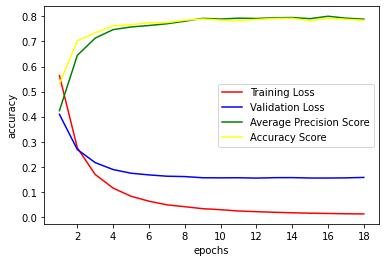

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# Training loss and validation loss plot
avg_prec, train_loss, val_loss, epoch = [], [], [], []
train_loss.append(train_losses)
val_loss.append(val_losses)
avg_prec.append(avg_precision_score)


    
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(np.arange(1, len(train_loss[0]) + 1), train_loss[0], color = 'red', label= "Training Loss")
ax.plot(np.arange(1, len(val_loss[0]) + 1), val_loss[0], color = 'blue', label="Validation Loss")
ax.plot(np.arange(1, len(avg_prec[0]) + 1), avg_prec[0], color = 'Green', label="Average Precision Score")
ax.plot(np.arange(1, len(eval_accuracies[0]) + 1), eval_accuracies[0], color = 'yellow', label="Accuracy Score")
ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")
ax.legend()


  


In [28]:
#Now we evaluate how our best model does for test set
_, report, conf_mat, prec, acc = val_epoch(best_model, test_loader, criterion, cuda_device)

pretty_classification_report_print(report, class_names=classLabels)




Validation:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,precision,recall,f1-score,support
airplane,0.96,1.00,0.98,22
bare-soil,0.82,0.74,0.78,136
buildings,0.88,0.83,0.85,129
cars,0.86,0.85,0.85,176
chaparral,1.00,0.92,0.96,24
court,0.89,0.57,0.70,14
dock,1.00,0.95,0.98,21
field,1.00,0.81,0.89,26
grass,0.87,0.83,0.85,196
mobile-home,0.82,0.95,0.88,19


In [85]:
#Average precision & Accuaracy score on test dataset

print("The Average Precision score of our model is:", prec)
print("The Accuracy score of our model is:", acc)

The Average Precision score of our model is: 0.8198165609502446
The Accuracy score of our model is: 0.8095578231292525


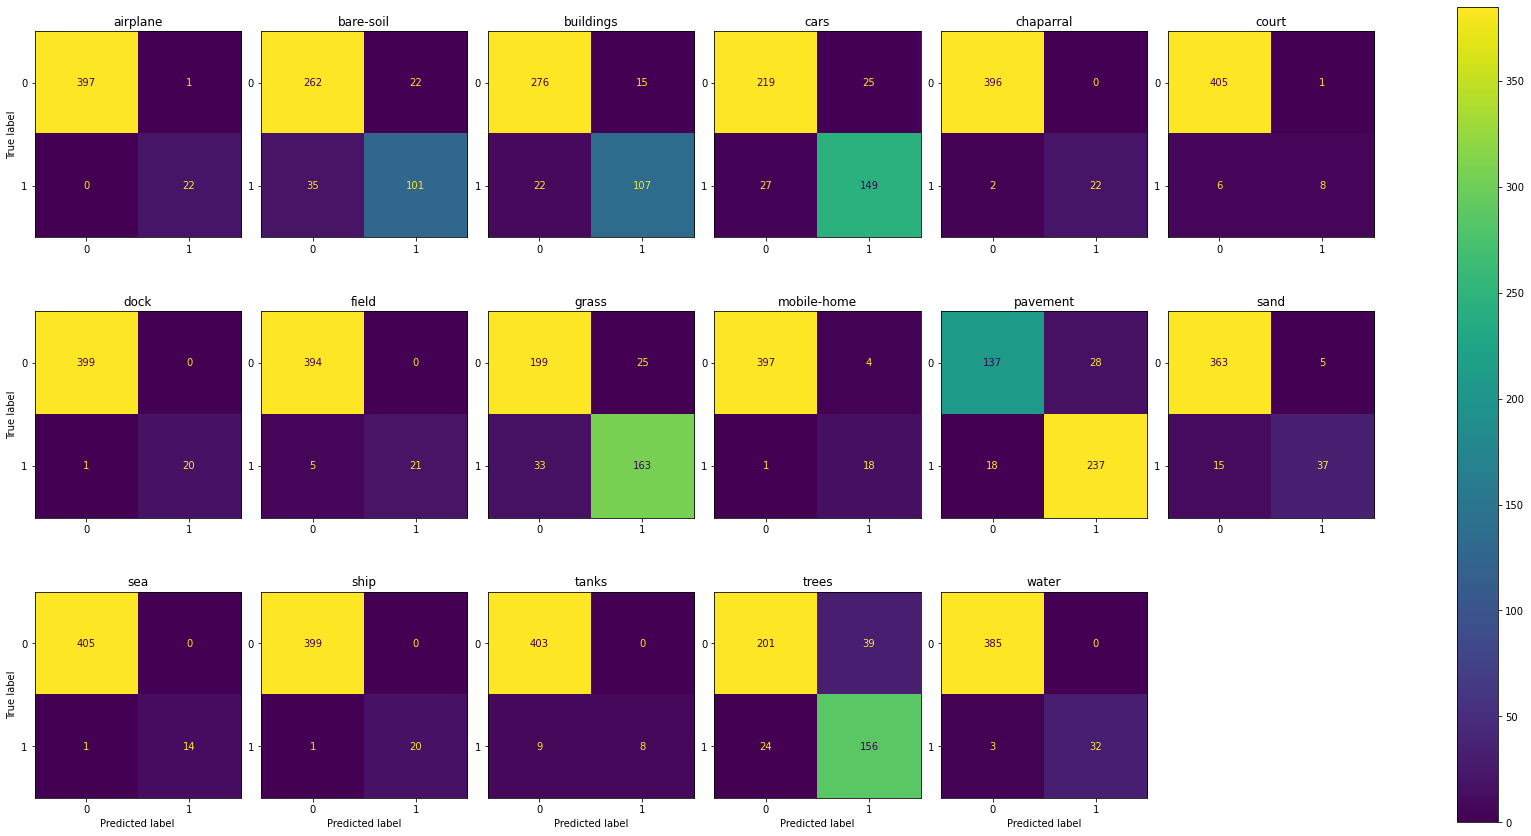

In [34]:
#Confusion Matrix of test dataset
prettify_multilabel_confusion_matrix(conf_mat, classLabels, normalize=False)


## Data Augmentation
Here we will apply three different data augmentation techniques:
1) A method that includes random affine transformation (e.g. degrees=10) and random auto-contrast
2) A method that consists of two or three augmentation methods that you select on your own
3) A method that includes the composed data augmentation technique RandAugment

### 1) Data Augmentation with random affine transformation (e.g. degrees=10) and random auto-contrast
Image rotation helps our model to become more robust to the changes in the orientation of objects. 
For various Data Augmentation techniques, please refer to the following link: http://www.neurotec.uni-bremen.de/drupal/node/30#torchvision.transforms.CenterCrop(size) && https://pytorch.org/vision/stable/transforms.html

In [73]:
ucm_mean = [0.595425, 0.3518577, 0.3225522]
ucm_std = [0.19303136, 0.12492529, 0.10577361]


tr_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomRotation(10),
        transforms.RandomAutocontrast(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

te_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomRotation(10),
        transforms.RandomAutocontrast(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

Text(0.5, 1.0, 'Transformed Image')

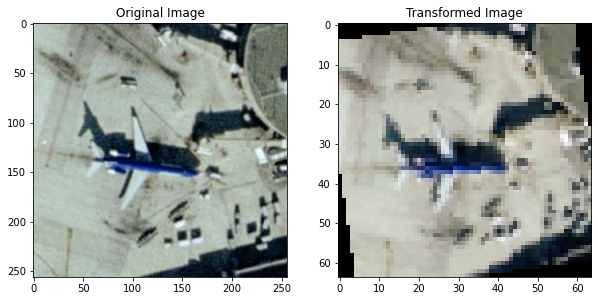

In [74]:
#We  wanna see how this transform affect our image

#Path declaration
path = os.path.join("/notebooks", "Hw3_data", "UCMerced_LandUse", "Images", "airplane", "")


#Import all images
from PIL import Image
import os, os.path

imgs = []
path = path
valid_images = [".tif"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs.append(Image.open(os.path.join(path,f)))

    
#Display original image
plane_image = imgs[0]



#Display transformed Image
rotate_img = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomRotation(10),
        transforms.RandomAutocontrast(p=0.5),
        
    ]
)
transformed_image = rotate_img(plane_image)


#Display Images
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(plane_image)
plt.title("Original Image")

          
fig.add_subplot(1,2,2)
plt.imshow(transformed_image)
plt.title("Transformed Image")




In [75]:
#Choose our parameter
batch_size = 32



In [76]:
trainset, valset, testset = get_dataset(
    "./Hw3_data/UCMerced_LandUse",
    tr_transform=tr_transform,
    multilabel=True
)

In [77]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [78]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 17) #21 - number of classes
model.to(cuda_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [79]:
import torch.optim as optim
from torch.optim import lr_scheduler


#Criterion
criterion = nn.BCEWithLogitsLoss().to(cuda_device)
#criterion = nn.CrossEntropyLoss()




# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00005)

In [80]:
eval_accuracies, avg_precision, train_loss, val_loss = [], [], [], []
#We keep epoch = 18 because after valdiation increases so overshoot
best_model, train_losses, val_losses, accuracy_scores, avg_precision_score = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=18,
    device=cuda_device,
)
eval_accuracies.append(accuracy_scores)

Epoch 1/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/18
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

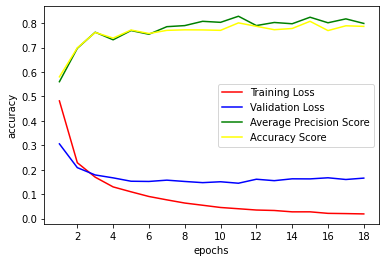

In [81]:
from matplotlib.ticker import MaxNLocator
# Training loss and validation loss plot
avg_prec, train_loss, val_loss, epoch = [], [], [], []
train_loss.append(train_losses)
val_loss.append(val_losses)
avg_prec.append(avg_precision_score)


    
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(np.arange(1, len(train_loss[0]) + 1), train_loss[0], color = 'red', label= "Training Loss")
ax.plot(np.arange(1, len(val_loss[0]) + 1), val_loss[0], color = 'blue', label="Validation Loss")
ax.plot(np.arange(1, len(avg_prec[0]) + 1), avg_prec[0], color = 'Green', label="Average Precision Score")
ax.plot(np.arange(1, len(eval_accuracies[0]) + 1), eval_accuracies[0], color = 'yellow', label="Accuracy Score")
ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")
ax.legend()

In [82]:
#Testing our model
_, report, conf_mat, prec, acc = val_epoch(best_model, test_loader, criterion, cuda_device)

pretty_classification_report_print(report, class_names=classLabels)

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,precision,recall,f1-score,support
airplane,1.00,0.95,0.97,20
bare-soil,0.75,0.72,0.74,141
buildings,0.84,0.83,0.84,131
cars,0.80,0.86,0.83,167
chaparral,1.00,0.89,0.94,28
court,0.86,0.33,0.48,18
dock,1.00,1.00,1.00,18
field,0.95,0.86,0.90,22
grass,0.80,0.91,0.85,174
mobile-home,1.00,0.95,0.97,19


In [83]:
print("The Average Precision score of our model is:", prec)
print("The Accuracy score of our model is:", acc)

The Average Precision score of our model is: 0.8198165609502446
The Accuracy score of our model is: 0.8095578231292525


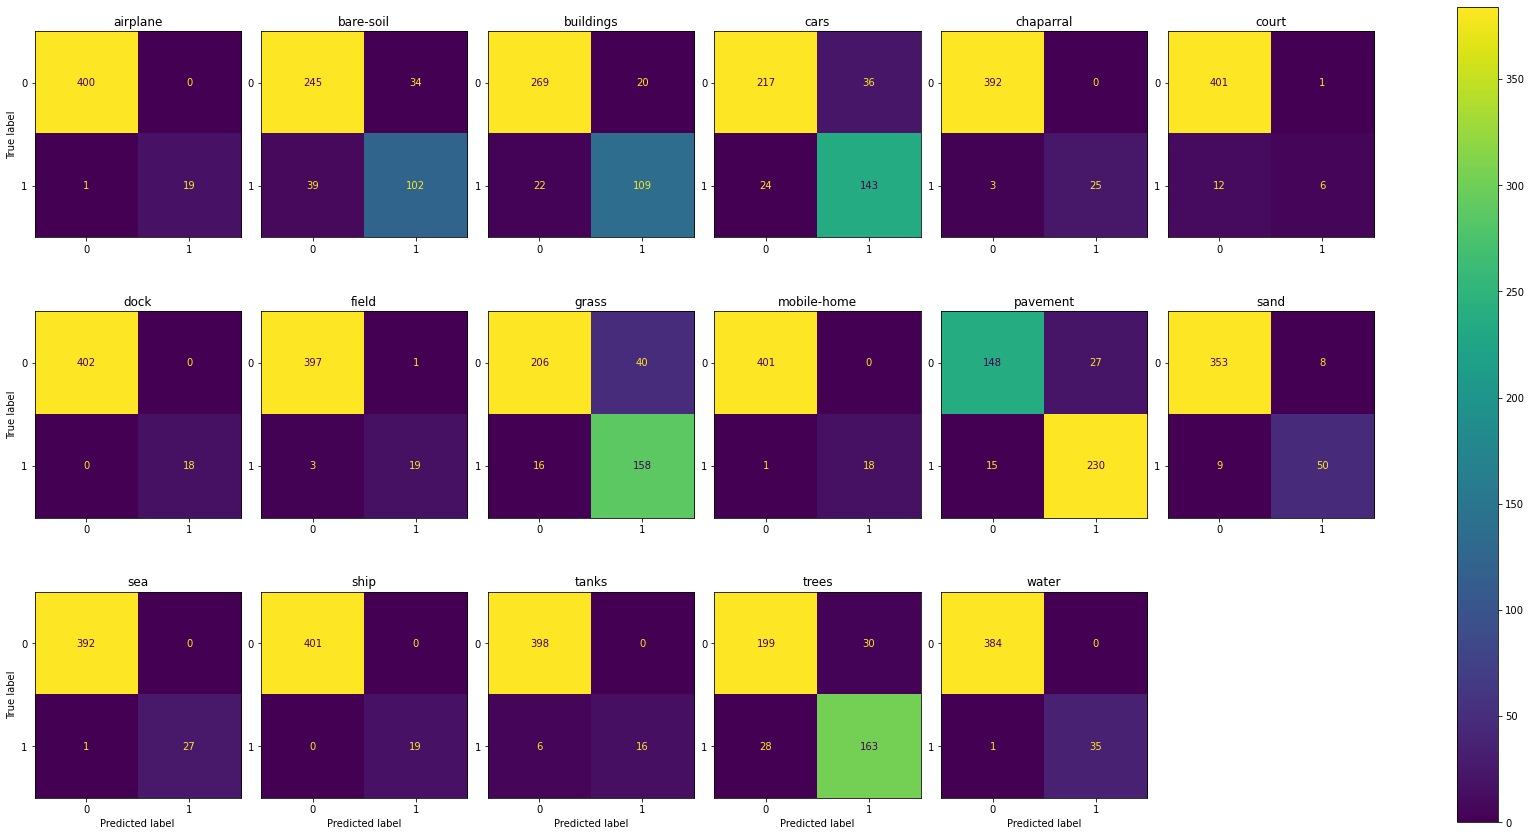

In [84]:
#Confusion Matrix
prettify_multilabel_confusion_matrix(conf_mat, classLabels, normalize=False)

### A method that consists of two or three augmentation methods that you select on your own
The Data Augmentation techniques we choose are:
1) Random Crop
2) Random Vertical Flip
3) Color Jitter

In [86]:
ucm_mean = [0.595425, 0.3518577, 0.3225522]
ucm_std = [0.19303136, 0.12492529, 0.10577361]


tr_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224,224)),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.5, contrast=0.3), 
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

te_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224,224)),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.5, contrast=0.3), 
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

Text(0.5, 1.0, 'Transformed Image 4')

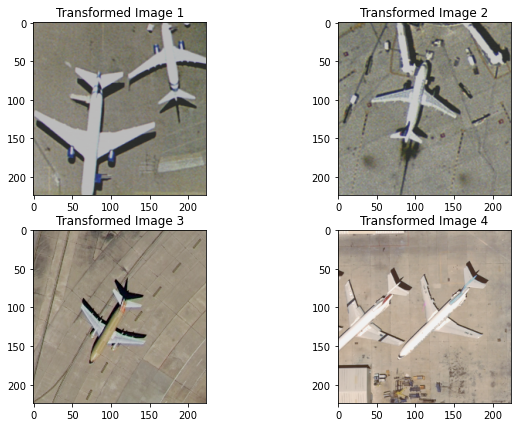

In [87]:
#We  wanna see how this transform affect our image

#Path declaration
path = os.path.join("/notebooks", "Hw3_data", "UCMerced_LandUse", "Images", "airplane", "")


#Import all images
from PIL import Image
import os, os.path

imgs = []
path = path
valid_images = [".tif"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs.append(Image.open(os.path.join(path,f)))

    


#Display transformed Image
rotate_img = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224,224)),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.5, contrast=0.3),
        
    ]
)


#Transform Images
transformed_image1 = rotate_img(imgs[1])
transformed_image2 = rotate_img(imgs[2])
transformed_image3 = rotate_img(imgs[3])
transformed_image4 = rotate_img(imgs[4])

#Display Images
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.imshow(transformed_image1)
plt.title("Transformed Image 1")

          
fig.add_subplot(2,2,2)
plt.imshow(transformed_image2)
plt.title("Transformed Image 2")

fig.add_subplot(2,2,3)
plt.imshow(transformed_image3)
plt.title("Transformed Image 3")

fig.add_subplot(2,2,4)
plt.imshow(transformed_image4)
plt.title("Transformed Image 4")




    
    



In [88]:
#Choose our parameter
batch_size = 32


In [89]:
trainset, valset, testset = get_dataset(
    "./Hw3_data/UCMerced_LandUse",
    tr_transform=tr_transform,
    multilabel=True
)

In [90]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [91]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 17) #21 - number of classes
model.to(cuda_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [92]:
import torch.optim as optim
from torch.optim import lr_scheduler


#Criterion
criterion = nn.BCEWithLogitsLoss().to(cuda_device)
#criterion = nn.CrossEntropyLoss()




# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00005)

In [93]:
eval_accuracies = []
avg_precision, train_loss, val_loss = [], [], []

best_model, train_losses, val_losses, accuracy_scores, avg_precision_score = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=20,
    device=cuda_device,
)
eval_accuracies.append(accuracy_scores)

Epoch 1/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/20
----------


Training:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

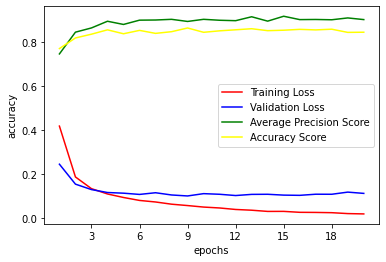

In [95]:
from matplotlib.ticker import MaxNLocator
# Training loss and validation loss plot
avg_prec, train_loss, val_loss, epoch = [], [], [], []
train_loss.append(train_losses)
val_loss.append(val_losses)
avg_prec.append(avg_precision_score)


    
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(np.arange(1, len(train_loss[0]) + 1), train_loss[0], color = 'red', label= "Training Loss")
ax.plot(np.arange(1, len(val_loss[0]) + 1), val_loss[0], color = 'blue', label="Validation Loss")
ax.plot(np.arange(1, len(avg_prec[0]) + 1), avg_prec[0], color = 'Green', label="Average Precision Score")
ax.plot(np.arange(1, len(eval_accuracies[0]) + 1), eval_accuracies[0], color = 'yellow', label="Accuracy Score")
ax.set_xlabel("epochs")
ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")
ax.legend()

In [94]:
_, report, conf_mat, prec, acc = val_epoch(best_model, test_loader, criterion, cuda_device)

pretty_classification_report_print(report, class_names=classLabels)

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,precision,recall,f1-score,support
airplane,1.00,0.92,0.96,12
bare-soil,0.73,0.77,0.75,142
buildings,0.95,0.84,0.89,145
cars,0.89,0.88,0.89,178
chaparral,1.00,1.00,1.00,23
court,1.00,0.81,0.89,21
dock,1.00,1.00,1.00,17
field,1.00,1.00,1.00,26
grass,0.81,0.87,0.84,200
mobile-home,1.00,0.91,0.95,23


In [96]:
print("The Average Precision score of our model is:", prec)
print("The Accuracy score of our model is:", acc)

The Average Precision score of our model is: 0.8854303664319689
The Accuracy score of our model is: 0.8356632653061233


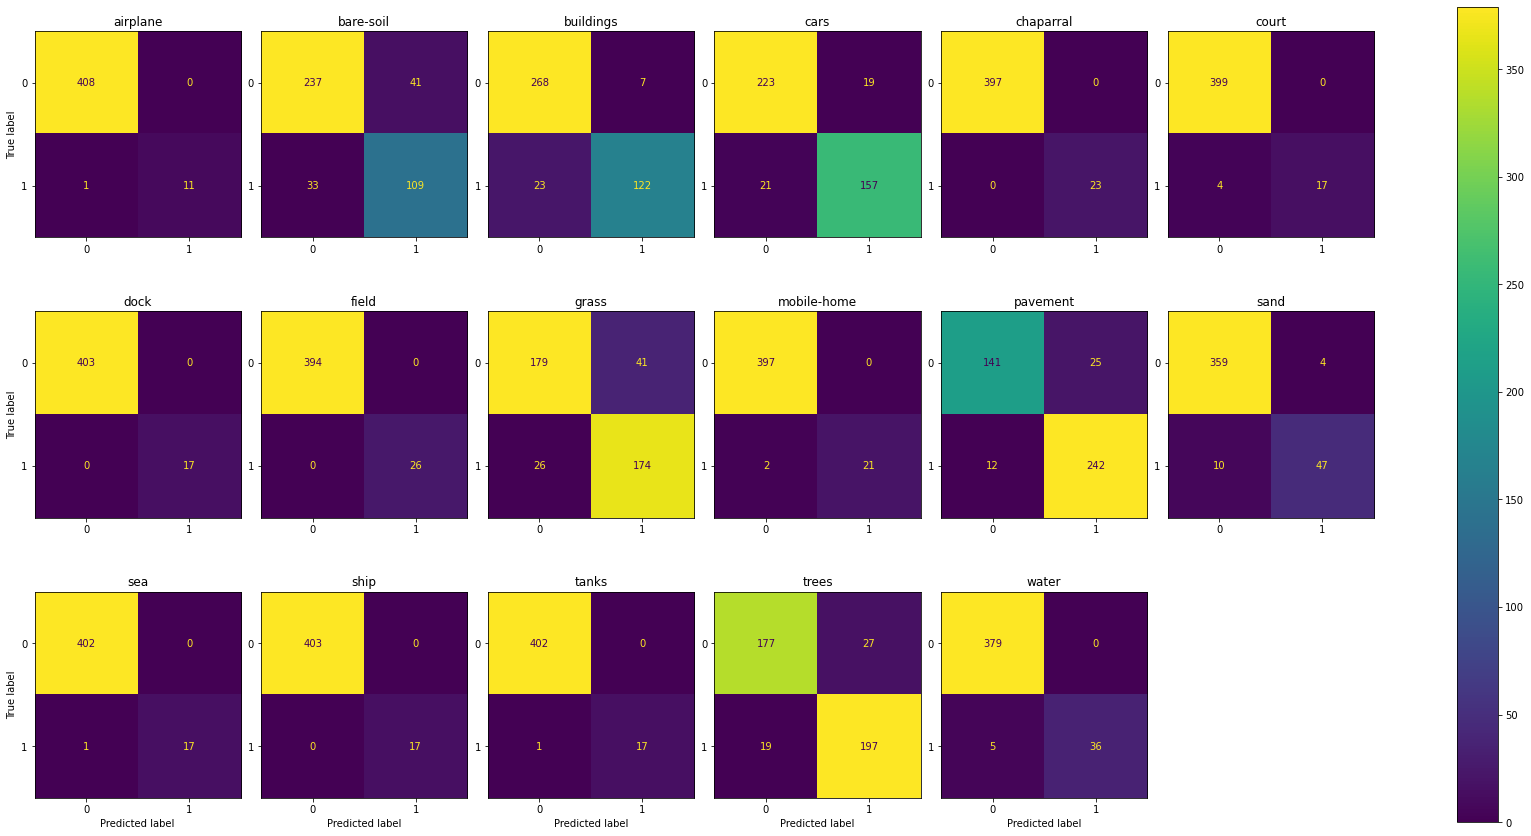

In [97]:
prettify_multilabel_confusion_matrix(conf_mat, classLabels, normalize=False)

### Data Augmentation: RandAugment


In [133]:
ucm_mean = [0.595425, 0.3518577, 0.3225522]
ucm_std = [0.19303136, 0.12492529, 0.10577361]




tr_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop(size=(128, 128)),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ColorJitter(brightness=0.5, contrast=0.3),
        transforms.RandAugment(4,10),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)


te_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop(size=(128, 128)),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ColorJitter(brightness=0.5, contrast=3),
        transforms.RandAugment(4,10),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)



"""
tr_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop((224,224)),
        transforms.RandomVerticalFlip(p=0.6),
        transforms.ColorJitter(brightness=0.7, contrast=0.5),
        transforms.RandAugment(5,8),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)


te_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop((224,224)),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.7, contrast=0.5),
        transforms.RandAugment(5,8),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)
"""


'\ntr_transform = transforms.Compose(\n    [\n        transforms.Resize((256, 256)),\n        transforms.RandomHorizontalFlip(p=0.5),\n        transforms.RandomCrop((224,224)),\n        transforms.RandomVerticalFlip(p=0.6),\n        transforms.ColorJitter(brightness=0.7, contrast=0.5),\n        transforms.RandAugment(5,8),\n        transforms.ToTensor(),\n        transforms.Normalize(mean=ucm_mean, std=ucm_std),\n    ]\n)\n\n\nte_transform = transforms.Compose(\n    [\n        transforms.Resize((256, 256)),\n        transforms.RandomHorizontalFlip(p=0.5),\n        transforms.RandomCrop((224,224)),\n        transforms.RandomVerticalFlip(p=0.5),\n        transforms.ColorJitter(brightness=0.7, contrast=0.5),\n        transforms.RandAugment(5,8),\n        transforms.ToTensor(),\n        transforms.Normalize(mean=ucm_mean, std=ucm_std),\n    ]\n)\n'

In [134]:
#Choose our parameter
batch_size = 64


In [135]:
trainset, valset, testset = get_dataset(
    "./Hw3_data/UCMerced_LandUse",
    tr_transform=tr_transform,
    multilabel=True
)

In [136]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [137]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 17) #21 - number of classes
model.to(cuda_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [138]:
import torch.optim as optim
from torch.optim import lr_scheduler


#Criterion
criterion = nn.BCEWithLogitsLoss().to(cuda_device)
#criterion = nn.CrossEntropyLoss()




# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00005)

In [139]:
eval_accuracies = []
avg_precision, train_loss, val_loss = [], [], []

best_model, train_losses, val_losses, accuracy_scores, avg_precision_score = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=50,
    device=cuda_device,
)
eval_accuracies.append(accuracy_scores)

Epoch 1/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/50
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

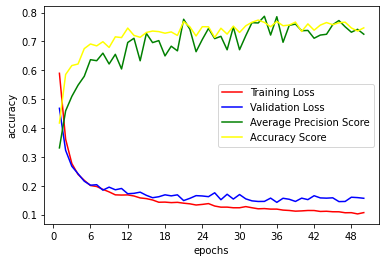

In [140]:
from matplotlib.ticker import MaxNLocator
# Training loss and validation loss plot
avg_prec, train_loss, val_loss, epoch = [], [], [], []
train_loss.append(train_losses)
val_loss.append(val_losses)
avg_prec.append(avg_precision_score)


    
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(np.arange(1, len(train_loss[0]) + 1), train_loss[0], color = 'red', label= "Training Loss")
ax.plot(np.arange(1, len(val_loss[0]) + 1), val_loss[0], color = 'blue', label="Validation Loss")
ax.plot(np.arange(1, len(avg_prec[0]) + 1), avg_prec[0], color = 'Green', label="Average Precision Score")
ax.plot(np.arange(1, len(eval_accuracies[0]) + 1), eval_accuracies[0], color = 'yellow', label="Accuracy Score")
ax.set_xlabel("epochs")
ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")
ax.legend()

In [141]:
_, report, conf_mat, prec, acc = val_epoch(best_model, test_loader, criterion, cuda_device)

pretty_classification_report_print(report, class_names=classLabels)

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,precision,recall,f1-score,support
airplane,1.00,0.84,0.91,25
bare-soil,0.81,0.69,0.74,150
buildings,0.88,0.83,0.86,161
cars,0.83,0.78,0.81,186
chaparral,0.94,0.83,0.88,18
court,1.00,0.67,0.80,21
dock,1.00,1.00,1.00,26
field,0.93,0.82,0.87,17
grass,0.87,0.82,0.84,184
mobile-home,0.95,0.76,0.84,25


In [143]:
print("The Average Precision score of our model is:", prec)
print("The Accuracy score of our model is:", acc)

The Average Precision score of our model is: 0.7833467601381193
The Accuracy score of our model is: 0.7773327664399102


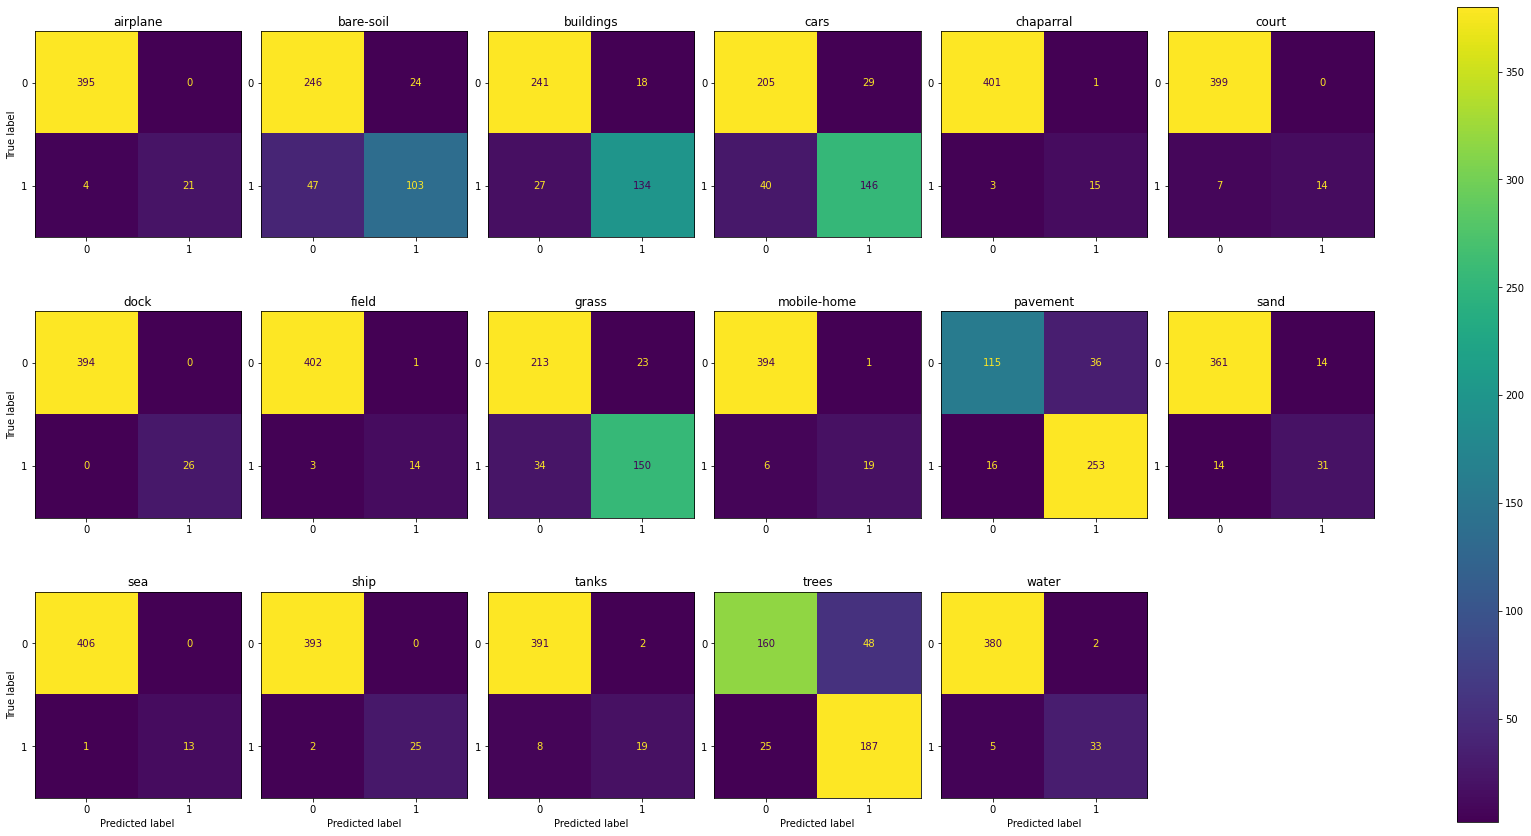

In [144]:
#Confusion Matrix
prettify_multilabel_confusion_matrix(conf_mat, classLabels, normalize=False)